In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# Load CSV, skipping first 10 rows and selecting only relevant columns
file_path = "feds200628.csv"  # Ensure correct file path
columns_to_use = ["Date", "BETA0", "BETA1", "BETA2", "BETA3", "TAU1", "TAU2"]

df = pd.read_csv(file_path, skiprows=9, usecols=columns_to_use)

# Convert Date column to datetime
df["Date"] = pd.to_datetime(df["Date"])

# Filter data for the period January 1995 - December 2024
df = df[(df["Date"] >= "1995-01-01") & (df["Date"] <= "2024-12-31")]


# Ensure that if the first trading day has missing data, move to the next available day
def get_first_valid_trading_day(group):
    return group.dropna(subset=["BETA0", "BETA1", "BETA2", "BETA3", "TAU1", "TAU2"]).iloc[0]

first_trading_day_params = df.groupby(df["Date"].dt.to_period("M")).apply(get_first_valid_trading_day).reset_index(drop=True)

# Define maturities (in years)
maturities = np.array([1, 2, 3, 5, 7, 10, 15, 20])

def nelson_siegel_svensson(beta0, beta1, beta2, beta3, tau1, tau2, maturities):
    """Calculate NSS yield curve for given maturities"""

    term = maturities  # Time to maturity
    factor1 = (1 - np.exp(-term / tau1)) / (term / tau1)
    factor2 = factor1 - np.exp(-term / tau1)
    factor3 = (1 - np.exp(-term / tau2)) / (term / tau2) - np.exp(-term / tau2)
    return beta0 + beta1 * factor1 + beta2 * factor2 + beta3 * factor3

# Nx360 matrix
monthly_yields = np.zeros(( len(maturities),len(first_trading_day_params)))

# Compute NSS yields for each month
for i, (_, row) in enumerate(first_trading_day_params.iterrows()):
    monthly_yields[:,i] = nelson_siegel_svensson(
        row["BETA0"], row["BETA1"], row["BETA2"], row["BETA3"],
        row["TAU1"], row["TAU2"], maturities
    )/100


In [ ]:

def simple_vasicek_kalman_filter(yields, maturities, kappa, theta, sigma, r0,p0,measurement_std,LL):

    # yields are a n_mat x n_timesteps matrix (nxt)
    # Number of time steps and maturities

    n_timesteps = yields.shape[1]
    n_maturities = len(maturities)

    # Time step (assuming daily trading data)
    dt = 1/12

    # Create arrays for storing results
    # NB these are not matrices they are 1D arrays (1xn_timeteps)
    r_estimates = np.zeros(n_timesteps)
    p_estimates = np.zeros(n_timesteps)

    # Set initial values
    r_estimates[0] = r0
    p_estimates[0] = p0

    # remember maturities is a nx1 column vector
    B_tau = (1 - np.exp(-kappa * maturities)) / kappa
    A_tau = (B_tau - maturities) * (theta - sigma**2/(2*kappa**2)) - (sigma**2 * B_tau**2) / (4*kappa)

    #nx1 column vectors
    H = np.array(-B_tau / maturities).reshape(-1, 1)
    h = np.array(-A_tau / maturities).reshape(-1, 1)

    #1x1 matrices
    # A=np.array(1-kappa*dt).reshape(1,1)
    # a=np.array(kappa*theta*dt).reshape(1,1)
    # Q=np.array(sigma**2*dt).reshape(1,1)
    A=np.array(  np.exp(-kappa*dt) ).reshape(1,1)
    a=np.array(  theta*(1-np.exp(-kappa*dt))  ).reshape(1,1)
    Q=np.array(  (sigma**2 / (2 * kappa)) * (1 - np.exp(-2 * kappa * dt)) ).reshape(1,1)

    #n_mat x n_mat
    R = measurement_std**2*np.identity(n_maturities)

    # Kalman filter iterations
    for t in range(1, n_timesteps):
        #---------- 1. PREDICTION STEP ----------#
        #1x1 but would be factorx1
        r_predicted = A @ r_estimates[t-1].reshape(1,1) + a
        # 1x1 but would be factorxfactor
        p_predicted = A @ p_estimates[t-1].reshape(1,1) @ A.T + Q


        #---------- 2. UPDATE STEP ----------#
        # n_matx1
        yields_predicted = h + H @ r_predicted
        #n_matx1 (coloumn vector)
        y_bar = yields[:,t].reshape(-1,1) - yields_predicted

        #n_mat x n_mat
        F = H @ p_predicted @ H.T + R

        #1xn_mat
        K = p_predicted @ H.T @ np.linalg.inv(F)

        # Update short rate estimate
        #remember r_estimates is a 1D array not a matrix
        r_estimates[t] = (r_predicted + K @ y_bar).item()


        #1x1
        term1=np.identity(r_predicted.shape[1]) - K @ H
        #1x1
        term2=K @ F @ K.T

        p_estimates[t] = (term1 @ p_predicted @ term1.T + term2).item()

        LL += log_likelihood_step(y_bar, F)

    return r_estimates, p_estimates, LL


def log_likelihood_step(y_bar, F):

    dy = y_bar.shape[0]
    sign, logdet = np.linalg.slogdet(F)
    if sign != 1:
        raise ValueError("Covariance matrix is not positive definite")
    inv_F = np.linalg.inv(F)
    term1 = -0.5 * dy * np.log(2 * np.pi)
    term2 = -0.5 * logdet
    term3 = -0.5 * y_bar.T @ inv_F @ y_bar
    return (term1 + term2 + term3).item()

def negative_log_likelihood(params, yields, maturities, r0, p0,LL0):
    kappa, theta, sigma,measurement_std = params
    _, _, log_likelihood = simple_vasicek_kalman_filter(
        yields, maturities, kappa, theta, sigma, r0, p0, measurement_std,LL0
    )
    return -log_likelihood  # We minimize, so take negative

Estimated kappa: 0.048084
Estimated theta: 0.118085
Estimated sigma: 0.019742
Estimated noise: 0.001000
log likelihood: -19229.031229


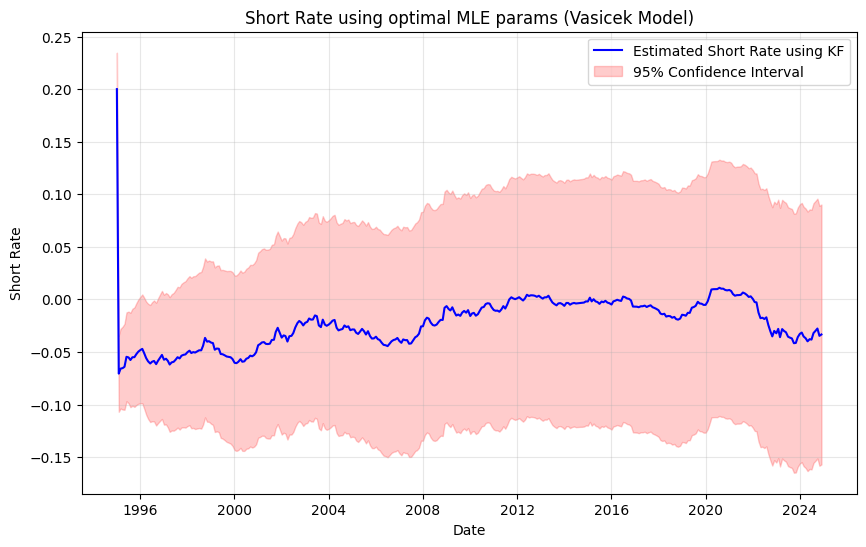

In [ ]:
#Set initial params for KF
kappa = 1.5
theta = 0.2
sigma = 0.03
measurement_std = 0.001  # Noise in yield measurements

r0_plus = theta
p0=(sigma**2)/(2*kappa)
LL0=0

# Maturities (in years)
maturities = np.array([1, 2, 3, 5, 7, 10, 15, 20]).reshape(8,1)

initial_guess = [kappa, theta, sigma, measurement_std]
bounds = [(1e-3, 2),     # kappa
          (0.0, 0.7),    # theta
          (1e-3, 0.1),   # sigma
          (1e-5, 1e-3)]  # measurement_std – don’t let this go too close to 0

result = minimize(
    negative_log_likelihood,
    initial_guess,
    args=(monthly_yields, maturities, r0_plus, p0,LL0),
    bounds=bounds,
    method='L-BFGS-B'
)

# Extract estimated parameters
estimated_kappa, estimated_theta, estimated_sigma,estimated_noise = result.x
print(f"Estimated kappa: {estimated_kappa:.6f}")
print(f"Estimated theta: {estimated_theta:.6f}")
print(f"Estimated sigma: {estimated_sigma:.6f}")
print(f"Estimated noise: {estimated_noise:.6f}")

# Apply Kalman filter
estimated_rates_opt, estimated_variances_opt,LL_opt= simple_vasicek_kalman_filter(
  monthly_yields, maturities,estimated_kappa, estimated_theta, estimated_sigma, r0_plus,p0,estimated_noise,LL0
)

print(f"log likelihood: {LL_opt:.6f}")
# Compute standard deviation from variance
std_dev = np.sqrt(estimated_variances_opt)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(first_trading_day_params["Date"],estimated_rates_opt, 'b-', label='Estimated Short Rate using KF')

# Add confidence bands (±2 standard deviations)
plt.fill_between(
    first_trading_day_params["Date"],
    estimated_rates_opt - 2 * std_dev,
    estimated_rates_opt + 2 * std_dev,
    color='red', alpha=0.2, label='95% Confidence Interval'
)

plt.title('Short Rate using optimal MLE params (Vasicek Model)')
plt.xlabel('Date')
plt.ylabel('Short Rate')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
def vasicek_yield_curve(r_t, kappa, theta, sigma, maturities):

    #Computes Vasicek zero-coupon bond yields over time for different maturities.

    T_steps = r_t.shape[0]
    n_maturities = len(maturities)

    yields = np.zeros((n_maturities, T_steps))

    for i, tau in enumerate(maturities):
        B = (1 - np.exp(-kappa * tau)) / kappa
        A = (theta - (sigma**2) / (2 * kappa**2)) * (B - tau) - (sigma**2) / (4 * kappa) * B**2

        # compute yield as: -ln(P(t, T))/tau
        yields[i, :] = (-A - B * r_t) / tau

    return yields


  # Compute yields from Vasicek model
vasicek_yields = vasicek_yield_curve(
    estimated_rates_opt, estimated_kappa, estimated_theta, estimated_sigma, maturities
)

# Compare to observed market yields
print(f"{'Maturity (Years)':<20}{'MSE':<15}{'R^2':<10}")
print("-" * 45)

for i in range(len(maturities)):
    observed = monthly_yields[i, 1:]
    estimated = vasicek_yields[i, 1:]

    mse = mean_squared_error(observed, estimated)
    r2 = r2_score(observed, estimated)

    print(f"{maturities[i].item():<20.2f}{mse:<15.6f}{r2:<10.4f}")


Maturity (Years)    MSE            R^2       
---------------------------------------------
1.00                0.000049       0.8944    
2.00                0.000024       0.9448    
3.00                0.000010       0.9747    
5.00                0.000002       0.9947    
7.00                0.000007       0.9764    
10.00               0.000021       0.9221    
15.00               0.000037       0.8527    
20.00               0.000043       0.8196    


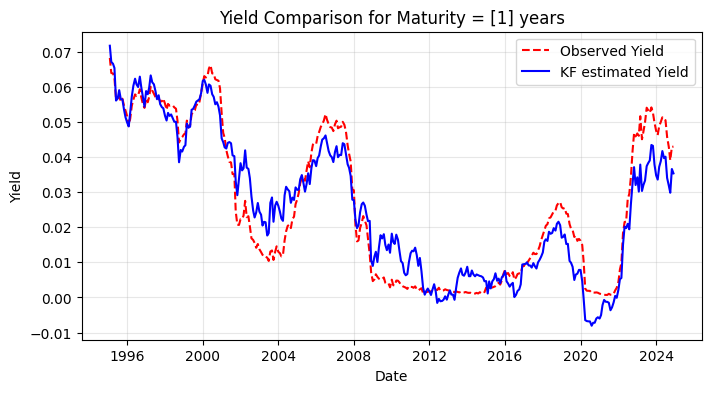

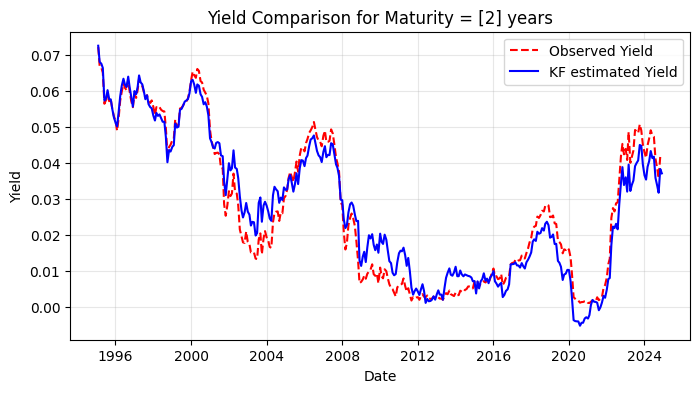

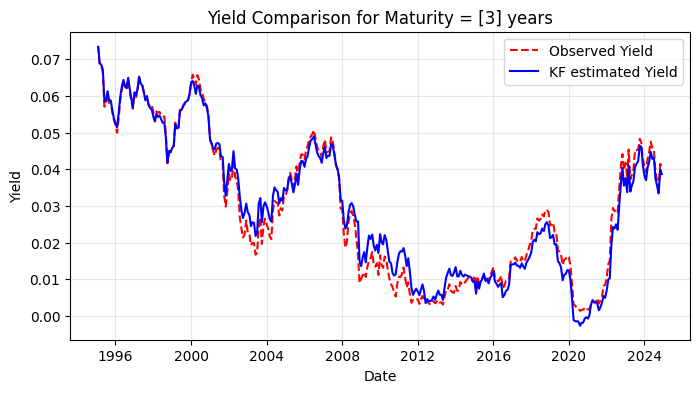

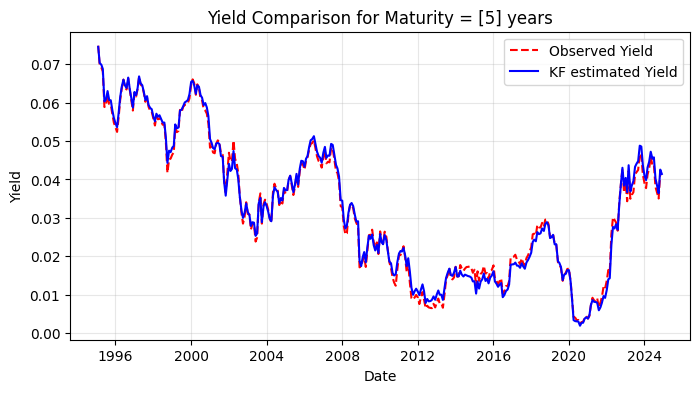

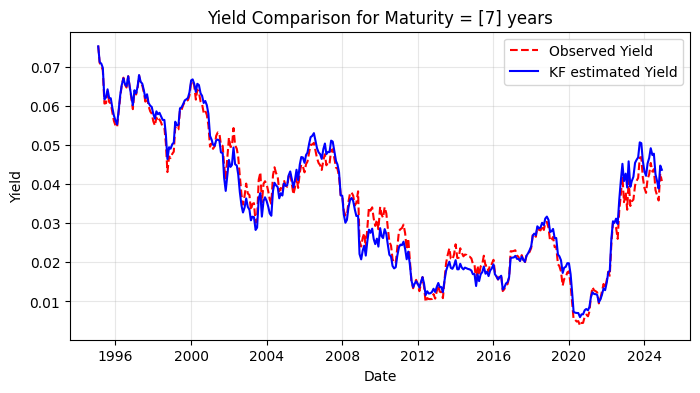

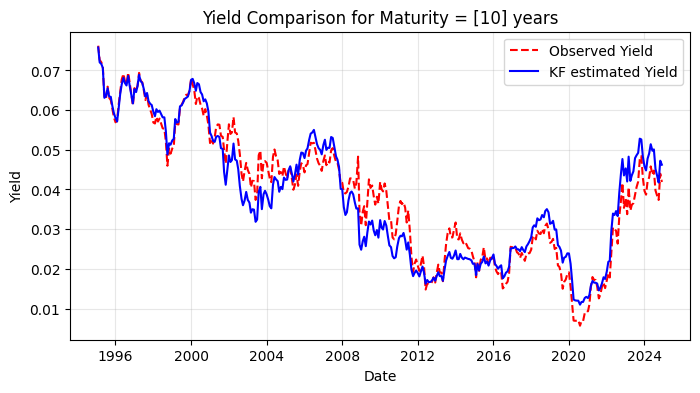

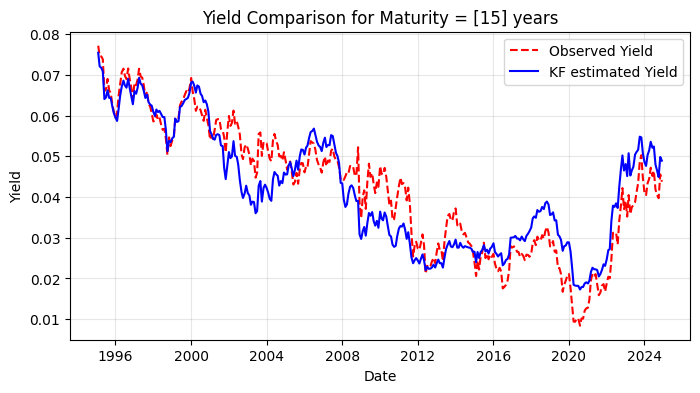

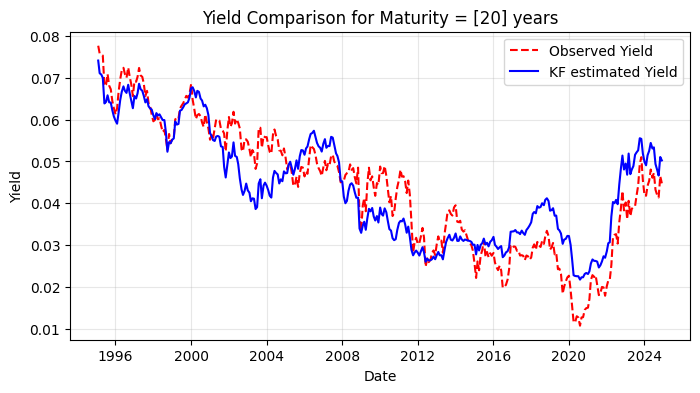

In [ ]:
for i in range(len(maturities)):
    plt.figure(figsize=(8, 4))
    plt.plot(first_trading_day_params["Date"][1:],monthly_yields[i,1:], 'r--', label='Observed Yield')
    plt.plot(first_trading_day_params["Date"][1:],vasicek_yields[i,1:], 'b-', label='KF estimated Yield')
    plt.title(f'Yield Comparison for Maturity = {maturities[i]} years')
    plt.xlabel('Date')
    plt.ylabel('Yield')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()